In [20]:
%%time
import os
import sys

# Clean up any previous installations
if os.path.exists('/kaggle/working/ChatGarment'):
    print("Removing old ChatGarment...")
    !rm -rf /kaggle/working/ChatGarment
    
if os.path.exists('/kaggle/working/GarmentCodeRC'):
    print("Removing old GarmentCodeRC...")
    !rm -rf /kaggle/working/GarmentCodeRC

# Clone repositories
os.chdir('/kaggle/working')

print("\n=== Cloning repositories ===")
!git clone -b kaggle --single-branch https://github.com/ShivaSubhanS/ChatGarment.git
print("✓ ChatGarment cloned")

!git clone -b kaggle --single-branch https://github.com/ShivaSubhanS/GarmentCodeRC.git
print("✓ GarmentCodeRC cloned")

print("\n=== Repository structure ===")
!ls -la /kaggle/working/

Removing old ChatGarment...
Removing old GarmentCodeRC...
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory

=== Cloning repositories ===
Cloning into 'ChatGarment'...
remote: Enumerating objects: 2522, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 2522 (delta 125), reused 125 (delta 103), pack-reused 2361 (from 1)
Receiving objects: 100% (2522/2522), 79.83 MiB | 47.58 MiB/s, done.
Resolving deltas: 100% (1530/1530), done.
✓ ChatGarment cloned
Cloning into 'GarmentCodeRC'...
remote: Enumerating objects: 9899, done.
remote: Counting objects: 100% (346/346), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 9899 (delta 323), reused 313 (delta 311), pack-reused 9553 (from 1)
Receiving objects: 100% (9899/9899), 138.60 MiB | 30.81 MiB/s, done.
Resolving deltas: 100% (7186/7186), done.
✓ GarmentCodeRC cloned

=== Repository structure ===

In [21]:
%%time
# Install ChatGarment dependencies
os.chdir('/kaggle/working/ChatGarment')
!pip install -q chumpy==0.70 smplx==0.1.28 json_repair==0.55.1 plyfile==1.1.3
!pip install deepspeed==0.15.0
!pip install svgpathtools CairoSVG
!pip install flash-attn --no-build-isolation

CPU times: user 182 ms, sys: 52.4 ms, total: 234 ms
Wall time: 13 s


In [ ]:
%%time
# Clone and build NvidiaWarp for GPU simulation
os.chdir('/kaggle/working')

# Check CUDA installation
print("=== Checking CUDA ===")
cuda_result = !nvcc --version 2>/dev/null | grep release
if cuda_result:
    print(f"✓ {cuda_result[0]}")
else:
    print("⚠ CUDA not found - make sure GPU runtime is enabled")

# Check if already exists
if not os.path.exists('/kaggle/working/NvidiaWarp-GarmentCode'):
    print("\n=== Cloning NvidiaWarp-GarmentCode ===")
    !git clone -b kaggle --single-branch https://github.com/ShivaSubhanS/NvidiaWarp-GarmentCode.git
    print("✓ NvidiaWarp-GarmentCode cloned")
else:
    print("\n✓ NvidiaWarp-GarmentCode already exists")

# Build Warp for CUDA (Kaggle GPU environment)
os.chdir('/kaggle/working/NvidiaWarp-GarmentCode')

print("\n=== Building Warp with CUDA support ===")
print("This will compile Warp kernels for GPU (~2-3 minutes)")

# Build with CUDA support (auto-detects CUDA path)
!python3 build_lib.py --mode release

print("\n✓ Warp built successfully")
print("  GPU kernels will be compiled on first use")

In [ ]:
import json
import os

# Fix paths in GarmentCodeRC configuration files for Kaggle environment
print("=== Configuring GarmentCodeRC paths for Kaggle ===")

# Fix system.json with Kaggle paths
system_json_path = '/kaggle/working/GarmentCodeRC/system.json'
system_config = {
    "output": "./Logs/",
    "datasets_path": "",
    "datasets_sim": "",
    "sim_configs_path": "/kaggle/working/GarmentCodeRC/assets/Sim_props",
    "bodies_default_path": "/kaggle/working/GarmentCodeRC/assets/bodies",
    "body_samples_path": ""
}

with open(system_json_path, 'w') as f:
    json.dump(system_config, f, indent=2)
print(f"✓ Updated {system_json_path}")

# Set environment variable to skip rendering (Kaggle is headless)
os.environ['KAGGLE_HEADLESS'] = '1'

print("\n✓ All paths configured for Kaggle environment")
print("  (Fabric texture path auto-resolved by simulation code)")
print("  (Rendering disabled - headless environment)")

In [22]:
import os

# Set model path environment variable (no copying needed!)
model_path = '/kaggle/input/llava-finetuned/pytorch_model.bin'

if os.path.exists(model_path):
    os.environ['CHATGARMENT_MODEL_PATH'] = model_path
    print(f"✓ Model found at: {model_path}")
    print(f"  Size: {os.path.getsize(model_path) / (1024**3):.2f} GB")
    print(f"  Environment variable set: CHATGARMENT_MODEL_PATH={model_path}")
else:
    print(f"❌ Model not found at {model_path}")
    print("Please ensure you've added the dataset 'llava-finetuned' to this notebook")
    print("Go to: Add data → Search for your uploaded model → Add")

✓ Model found at: /kaggle/input/llava-finetuned/pytorch_model.bin
  Size: 13.96 GB
  Environment variable set: CHATGARMENT_MODEL_PATH=/kaggle/input/llava-finetuned/pytorch_model.bin


✓ Copied test image: d77c6f5d4856831878eadb7fe3c8b180bfa9e9ad4a14936ac10a1697bb3c054f.png
  Destination: /kaggle/working/ChatGarment/test_image/d77c6f5d4856831878eadb7fe3c8b180bfa9e9ad4a14936ac10a1697bb3c054f.png

Test image:


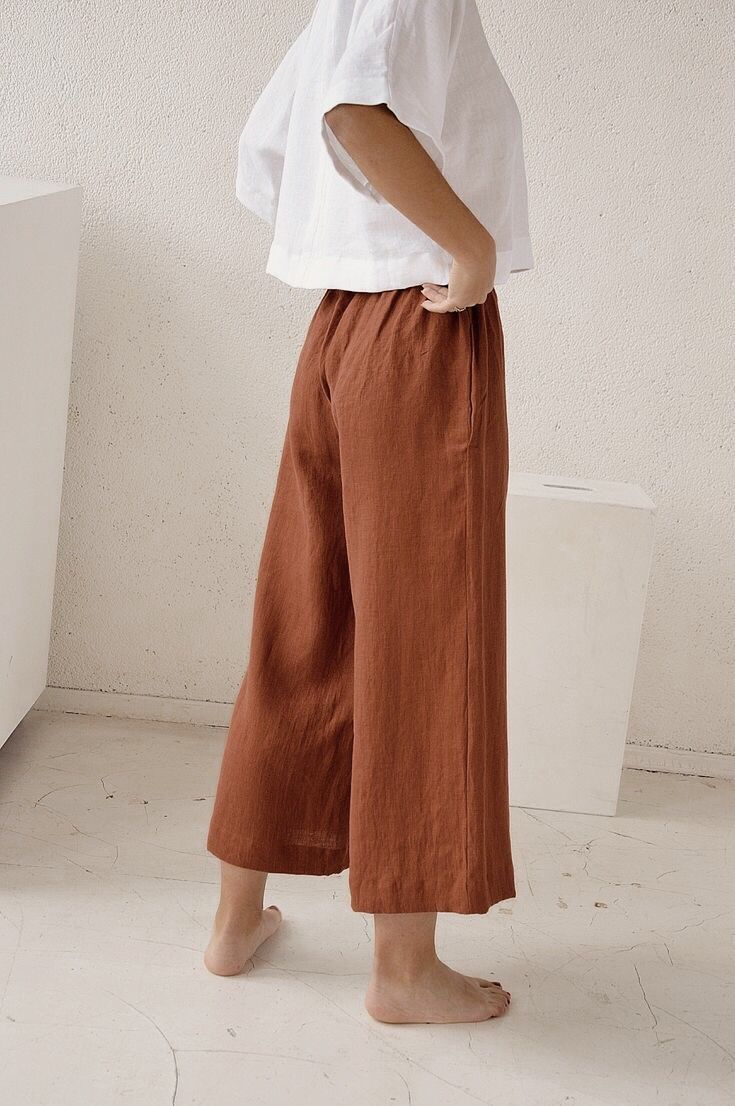

In [23]:
import os
import shutil
import glob

os.chdir('/kaggle/working/ChatGarment')

# Create test directory for single image
test_img_dir = '/kaggle/working/ChatGarment/test_image'
os.makedirs(test_img_dir, exist_ok=True)

# Find first image in example_data
example_imgs = glob.glob('example_data/example_imgs/*.[jp][pn]g')
if example_imgs:
    test_img = example_imgs[0]
    dest_img = os.path.join(test_img_dir, os.path.basename(test_img))
    shutil.copy(test_img, dest_img)
    print(f"✓ Copied test image: {os.path.basename(test_img)}")
    print(f"  Destination: {dest_img}")
    
    # Display the image
    from IPython.display import Image, display
    print("\nTest image:")
    display(Image(filename=dest_img, width=400))
else:
    print("❌ No example images found")

In [24]:
%%time
os.chdir('/kaggle/working/ChatGarment')

# Run image-based reconstruction (2-step CoT) on single image
print("=== Starting image-based reconstruction ===")
print("This will generate 2D sewing patterns (JSON specification)")
print("You can run 3D simulation locally after downloading the results\n")

!bash scripts/v1_5/evaluate_garment_v2_imggen_2step.sh test_image/

print("\n=== Reconstruction complete ===")

=== Starting image-based reconstruction ===
This will generate 2D sewing patterns (JSON specification)
You can run 3D simulation locally after downloading the results

[2026-02-15 08:04:45,768] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2026-02-15 08:04:51.767196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771142691.789617    1015 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771142691.796498    1015 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771142691.814762    1015 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the sa

In [ ]:
%%time
# Install GarmentCode simulation dependencies
print("=== Installing simulation dependencies ===")
!pip install -q pyyaml scipy matplotlib pillow
!pip install -q libigl  # Geometry processing library

# Add NvidiaWarp-GarmentCode to Python path
import sys
sys.path.insert(0, '/kaggle/working/NvidiaWarp-GarmentCode')

print("✓ Simulation dependencies installed")
print("✓ NvidiaWarp added to Python path")

In [ ]:
%%time
import glob
import os
import sys
import subprocess

os.chdir('/kaggle/working/ChatGarment')

# Dynamically find all generated pattern JSON files
print("=== Searching for generated patterns ===")
json_patterns = glob.glob('runs/*/*_img_recon/vis_new/valid_garment_*/valid_garment_*/*_specification.json')

if not json_patterns:
    print("❌ No pattern files found. Make sure the previous cell completed successfully.")
    sys.exit(1)

print(f"✓ Found {len(json_patterns)} pattern(s):\n")
for json_path in json_patterns:
    garment_type = 'upper' if 'upper' in json_path else 'lower'
    print(f"  • {garment_type} garment: {os.path.basename(json_path)}")

# Verify GPU availability
print("\n=== GPU Check ===")
import torch
if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠ No GPU detected - simulation will be slow")

# Run 3D simulation for each garment
print("\n=== Starting 3D Simulation ===")
print("This will generate 3D OBJ meshes using physics-based draping\n")

for json_path in json_patterns:
    garment_type = 'upper' if 'upper' in json_path else 'lower'
    print(f"→ Simulating {garment_type} garment...")
    
    # Run simulation using subprocess for proper error handling
    result = subprocess.run(
        ['python', 'run_garmentcode_sim.py', '--json_spec_file', json_path],
        capture_output=False
    )
    
    if result.returncode != 0:
        print(f"  ⚠ Warning: Simulation returned code {result.returncode}")
    else:
        print(f"  ✓ {garment_type.capitalize()} garment complete\n")

print("✓ All simulations completed!")

In [ ]:
import glob
import os
import shutil
import zipfile

os.chdir('/kaggle/working/ChatGarment')

# Find all generated simulation OBJ files
print("=== Collecting Simulation Results ===\n")
sim_obj_files = glob.glob('runs/*/*_img_recon/vis_new/valid_garment_*/valid_garment_*/valid_garment_*/*_sim.obj')

if not sim_obj_files:
    print("❌ No simulation OBJ files found.")
    print("   Make sure the previous simulation cell completed successfully.")
else:
    print(f"✓ Found {len(sim_obj_files)} simulated mesh(es):\n")
    
    # Create output directory
    output_dir = '/kaggle/working/garment_sim_results'
    os.makedirs(output_dir, exist_ok=True)
    
    # Copy OBJ files and their associated textures/materials
    for obj_file in sim_obj_files:
        garment_dir = os.path.dirname(obj_file)
        garment_name = os.path.basename(garment_dir)
        garment_type = 'upper' if 'upper' in garment_name else 'lower'
        
        print(f"  Processing {garment_type} garment...")
        
        # Create subdirectory for this garment
        out_subdir = os.path.join(output_dir, garment_name)
        os.makedirs(out_subdir, exist_ok=True)
        
        # Files to include: sim.obj, textures, material (no renders in headless mode)
        patterns = [
            f'{garment_name}_sim.obj',
            f'{garment_name}_material.mtl',
            f'{garment_name}_texture*.png',
        ]
        
        for pattern in patterns:
            files = glob.glob(os.path.join(garment_dir, pattern))
            for file in files:
                dest = os.path.join(out_subdir, os.path.basename(file))
                shutil.copy2(file, dest)
                print(f"    ✓ {os.path.basename(file)}")
    
    # Create zip file
    print("\n=== Creating Download Package ===")
    zip_path = '/kaggle/working/garment_sim_meshes.zip'
    
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)
    
    zip_size = os.path.getsize(zip_path) / (1024**2)
    print(f"✓ Package created: garment_sim_meshes.zip ({zip_size:.2f} MB)")
    print("\n📦 Download the zip file to import meshes into Blender!")
    print("   File → Import → Wavefront (.obj) → Select *_sim.obj files")
    
    # Show summary
    print(f"\n=== Contents Summary ===")
    for obj_file in sim_obj_files:
        garment_type = 'upper' if 'upper' in obj_file else 'lower'
        size_mb = os.path.getsize(obj_file) / (1024**2)
        print(f"  • {garment_type.capitalize()} garment: {size_mb:.1f} MB")

❌ No output directory found. Check if inference completed successfully.
